In [11]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import t

In [12]:
# Load datasets
df1 = pd.read_csv("C:\\YEAR1\\NMVOC\\Data\\processed_c3h8.csv", parse_dates=['datetime'])
df2 = pd.read_csv("C:\\YEAR1\\NMVOC\\Data\\processed_CH4.csv", parse_dates=['datetime'])
df3 = pd.read_csv("C:\\YEAR1\\NMVOC\\Data\\processed_CO.csv", parse_dates=['datetime'])


# Merge all datasets on 'datetime' using an inner join
merged_df = df1.merge(df2, on='datetime', how='inner') \
               .merge(df3, on='datetime', how='inner') 
               

# Display result
print(merged_df)

                 datetime  C3H8_ppb  CH4_ppb    CO_ppb
0     2011-06-17 11:00:00   0.14212  1844.85   93.1660
1     2011-06-17 13:00:00   0.15840  1856.25  102.3575
2     2011-06-17 17:00:00   0.08721  1835.98   93.6670
3     2011-06-17 23:00:00   0.05857  1839.14   90.8355
4     2011-06-18 01:00:00   0.06136  1839.20   92.8540
...                   ...       ...      ...       ...
28259 2023-12-31 02:00:00   0.07656  1976.99  109.9230
28260 2023-12-31 04:00:00   0.11815  1979.04  110.0000
28261 2023-12-31 05:00:00   0.10664  1981.66  112.3530
28262 2023-12-31 07:00:00   0.10012  1984.29  116.3860
28263 2023-12-31 08:00:00   0.11116  1983.77  116.5760

[28264 rows x 4 columns]


In [13]:
# helper columns with  hour, month, year
#df['hour'] = df['starttime_dt'].dt.hour
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['year'] = merged_df['datetime'].dt.year
merged_df['date'] = merged_df['datetime'].dt.date
merged_df['day_m'] = merged_df['datetime'].dt.day
merged_df['day'] = merged_df['datetime'].dt.dayofyear
merged_df["hour"] = merged_df['datetime'].dt.hour
merged_df

,datetime,C3H8_ppb,CH4_ppb,CO_ppb,month,year,date,day_m,day,hour
0,2011-06-17 11:00:00,0.14212,1844.85,93.1660,6,2011,2011-06-17,17,168,11
1,2011-06-17 13:00:00,0.15840,1856.25,102.3575,6,2011,2011-06-17,17,168,13
2,2011-06-17 17:00:00,0.08721,1835.98,93.6670,6,2011,2011-06-17,17,168,17
3,2011-06-17 23:00:00,0.05857,1839.14,90.8355,6,2011,2011-06-17,17,168,23
4,2011-06-18 01:00:00,0.06136,1839.20,92.8540,6,2011,2011-06-18,18,169,1
...,...,...,...,...,...,...,...,...,...,...
28259,2023-12-31 02:00:00,0.07656,1976.99,109.9230,12,2023,2023-12-31,31,365,2
28260,2023-12-31 04:00:00,0.11815,1979.04,110.0000,12,2023,2023-12-31,31,365,4
28261,2023-12-31 05:00:00,0.10664,1981.66,112.3530,12,2023,2023-12-31,31,365,5
28262,2023-12-31 07:00:00,0.10012,1984.29,116.3860,12,2023,2023-12-31,31,365,7


In [14]:

# Ensure 'date' is datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Add season (DJF, MAM, JJA, SON)

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

merged_df['season'] = merged_df['month'].apply(get_season)

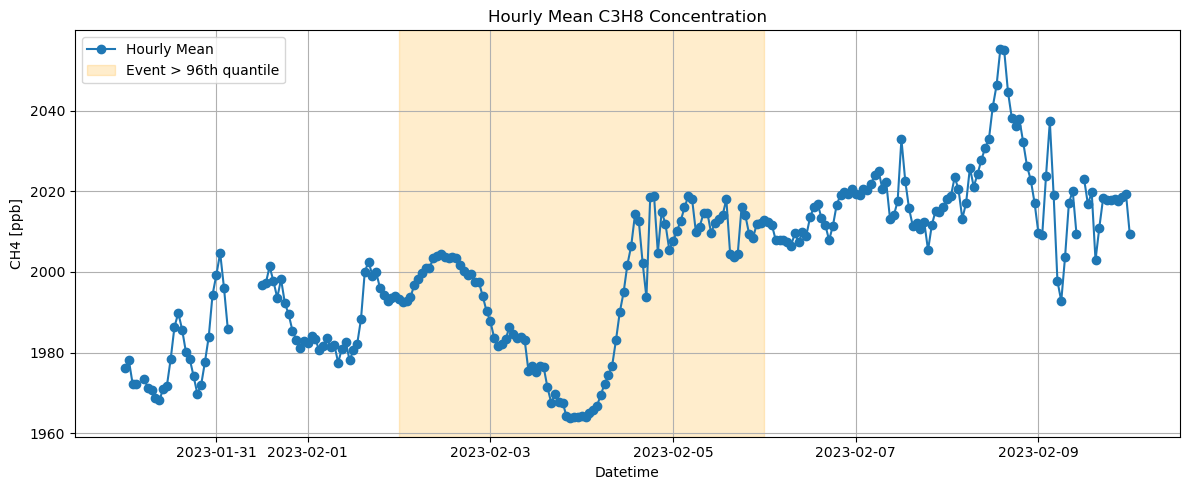

In [8]:
#plot hourly mean values between '2022-04-03'	annd '2022-04-08' (event above 96th quantile: )'2022-04-04'	annd '2022-04-07' )

# Plot hourly mean values between '2022-04-03' and '2022-04-08' (event above 96th quantile: '2022-04-04' to '2022-04-07')

# Filter the date range in the main df
mask = (df['datetime'] >= '2023-01-30') & (df['datetime'] <= '2023-02-10')
filtered = df.loc[mask].copy()

# Set datetime as index for resampling
filtered = filtered.set_index('datetime')

# Resample to hourly mean (only numeric column)
hourly_mean = filtered['CH4_ppb'].resample('h').mean().to_frame()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(hourly_mean.index, hourly_mean['CH4_ppb'], marker='o', linestyle='-', label='Hourly Mean')

# Highlight the event period
plt.axvspan(pd.Timestamp('2023-02-02'), pd.Timestamp('2023-02-05 23:59:59'), color='orange', alpha=0.2, label='Event > 96th quantile')

plt.title('Hourly Mean C3H8 Concentration')
plt.xlabel('Datetime')
plt.ylabel('CH4 [ppb]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


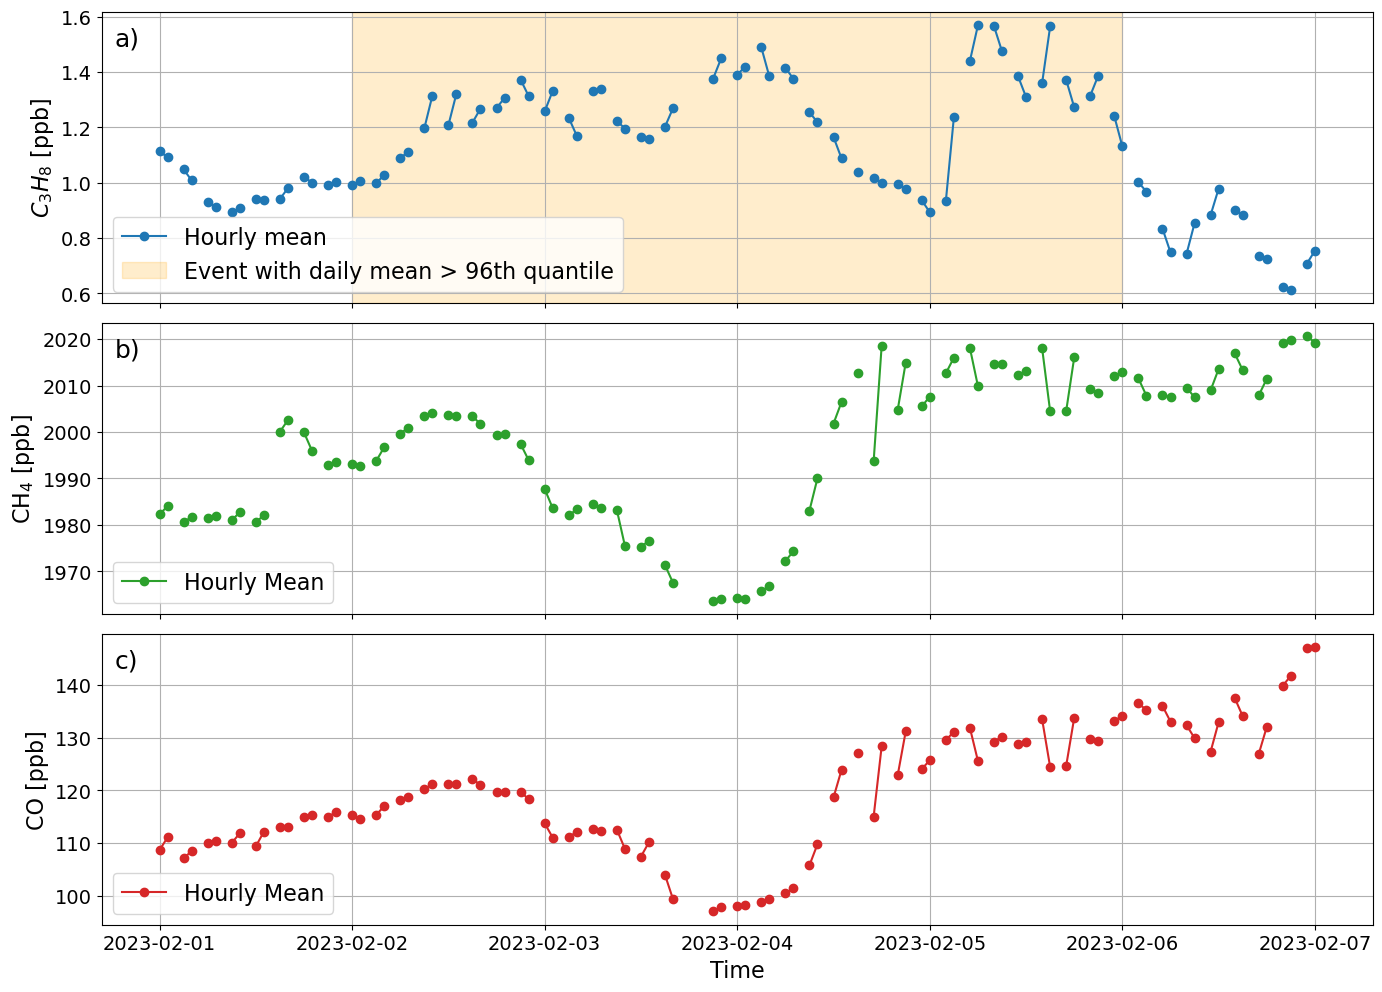

In [10]:
# Filter date range
mask = (merged_df['datetime'] >= '2023-02-01') & (merged_df['datetime'] <= '2023-02-07')
filtered = merged_df.loc[mask].copy()

# Set datetime as index for resampling
filtered = filtered.set_index('datetime')

# Resample to hourly mean for each gas
c3h8_hourly = filtered['C3H8_ppb'].resample('h').mean()
ch4_hourly = filtered['CH4_ppb'].resample('h').mean()
co_hourly = filtered['CO_ppb'].resample('h').mean()

# Create figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Define event period
event_start = pd.Timestamp('2023-02-02')
event_end = pd.Timestamp('2023-02-05 23:59:59')

# Panel a) - C3H8
axs[0].plot(c3h8_hourly.index, c3h8_hourly, marker='o', linestyle='-', label='Hourly Mean', color='tab:blue')
axs[0].axvspan(event_start, event_end, color='orange', alpha=0.2, label='Event > 96th quantile')
axs[0].set_ylabel('$C_3H_8$ [ppb]', fontsize=16)
axs[0].legend(['Hourly mean','Event with daily mean > 96th quantile' ], fontsize=16)
axs[0].grid(True)
axs[0].text(0.01, 0.95, 'a)', transform=axs[0].transAxes, fontsize=18, va='top', ha='left')

# Panel b) - CH4
axs[1].plot(ch4_hourly.index, ch4_hourly, marker='o', linestyle='-', label='Hourly Mean', color='tab:green')
axs[1].set_ylabel('CH$_4$ [ppb]', fontsize=16)
axs[1].legend(fontsize=16)
axs[1].grid(True)
axs[1].text(0.01, 0.95, 'b)', transform=axs[1].transAxes, fontsize=18, va='top', ha='left')

# Panel c) - CO
axs[2].plot(co_hourly.index, co_hourly, marker='o', linestyle='-', label='Hourly Mean', color='tab:red')
axs[2].set_ylabel('CO [ppb]', fontsize=16)
axs[2].set_xlabel('Time', fontsize=16)
axs[2].legend( fontsize=16)
axs[2].grid(True)
axs[2].text(0.01, 0.95, 'c)', transform=axs[2].transAxes, fontsize=18, va='top', ha='left')

# Set tick label font sizes
for ax in axs:
    ax.tick_params(axis='both', labelsize=14)

# Layout and show
plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_high_event_feb23.png", dpi=300)
plt.show()


In [22]:
#To calculate the Pearson correlation coefficients between the hourly data 

# Filter data between Feb 1 and Feb 7, 2023
mask = (merged_df['datetime'] >= '2023-02-01') & (merged_df['datetime'] <= '2023-02-07 23:59:59')
daily_filtered = merged_df.loc[mask].copy()

# Set datetime as index and resample to hourly (only numeric columns)
daily_filtered.set_index('datetime', inplace=True)
numeric_cols = ['C3H8_ppb', 'CH4_ppb', 'CO_ppb']
hourly = daily_filtered[numeric_cols].resample('H').mean()

# Group by date and compute pairwise Pearson correlations
correlations_by_day = {}

for date, group in hourly.groupby(hourly.index.date):
    # Drop rows with missing values for reliable correlation computation
    daily_data = group[['C3H8_ppb', 'CH4_ppb', 'CO_ppb']].dropna()
    if not daily_data.empty:
        corr_matrix = daily_data.corr(method='pearson')
        correlations_by_day[pd.to_datetime(date).strftime('%Y-%m-%d')] = corr_matrix

# Display results
for day, corr in correlations_by_day.items():
    print(f"\nDate: {day}")
    print(corr.round(3))
# Combine all correlation matrices into a single DataFrame for Feb 1 to Feb 7
corr_combined = pd.concat(
    {k: v for k, v in correlations_by_day.items() if '2023-02-01' <= k <= '2023-02-07'},
    axis=0
)
corr_combined.round(3).to_csv("C:\\YEAR1\\NMVOC\\figures\\corr_event_Feb23.csv")


Date: 2023-02-01
          C3H8_ppb  CH4_ppb  CO_ppb
C3H8_ppb     1.000    0.094  -0.078
CH4_ppb      0.094    1.000   0.786
CO_ppb      -0.078    0.786   1.000

Date: 2023-02-02
          C3H8_ppb  CH4_ppb  CO_ppb
C3H8_ppb     1.000    0.532   0.798
CH4_ppb      0.532    1.000   0.906
CO_ppb       0.798    0.906   1.000

Date: 2023-02-03
          C3H8_ppb  CH4_ppb  CO_ppb
C3H8_ppb     1.000   -0.315  -0.445
CH4_ppb     -0.315    1.000   0.974
CO_ppb      -0.445    0.974   1.000

Date: 2023-02-04
          C3H8_ppb  CH4_ppb  CO_ppb
C3H8_ppb     1.000   -0.938  -0.946
CH4_ppb     -0.938    1.000   0.990
CO_ppb      -0.946    0.990   1.000

Date: 2023-02-05
          C3H8_ppb  CH4_ppb  CO_ppb
C3H8_ppb     1.000    0.009  -0.116
CH4_ppb      0.009    1.000   0.831
CO_ppb      -0.116    0.831   1.000

Date: 2023-02-06
          C3H8_ppb  CH4_ppb  CO_ppb
C3H8_ppb     1.000   -0.325   -0.28
CH4_ppb     -0.325    1.000    0.81
CO_ppb      -0.280    0.810    1.00

Date: 2023-02-07
          

C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_8672\284554050.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = daily_filtered[numeric_cols].resample('H').mean()
